# **CSE655 Homework 2**

* **GTU Artificial Intelligence MSc.**
* **Student Name:** Berkin Barış Yılmaz
* **ID:** 244201001109

## **Part 1: Digit Recognition Using CNNs**

In [2]:
# Imports
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

In [4]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

print("Train Size : ", len(x_train))
print("Test Size : ", len(x_test))
print("Input Shape :", len(x_train[0][0]), "x", len(x_train[0]))

Train Size :  60000
Test Size :  10000
Input Shape : 28 x 28


In [5]:
# Model
model = models.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)), 
    layers.Conv2D(24, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(36, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8807 - loss: 0.3671
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9837 - loss: 0.0511
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9889 - loss: 0.0361
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9925 - loss: 0.0248
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9932 - loss: 0.0223


In [6]:
# Evaluation
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9847 - loss: 0.0463
Test Accuracy: 0.9879000186920166


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


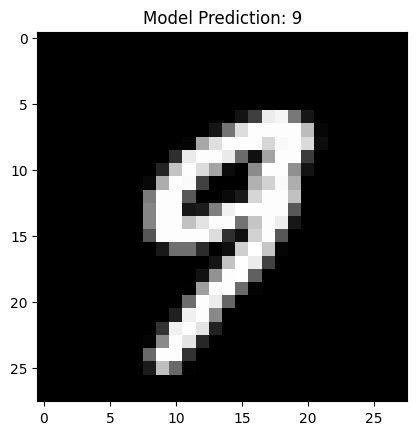

In [70]:
# Select a random index
xrand = random.randint(0, len(x_test) - 1)
xn = x_test[xrand].reshape(1, 28, 28, 1)  # Add batch dimension for prediction
predicted = model.predict(xn)

# Display the image
plt.imshow(x_test[xrand], cmap='gray')
plt.title(f"Model Prediction: {predicted.argmax()}")
plt.show()


## **Part 1 Conclusion**

The training and prediction time for a model with 28x28 input is considerably short. Using 60,000 images from the MNIST dataset for training, this brief process achieved an accuracy of 98.8%. Model layers : (Conv2D : 3x3 relu)(24) -> (PoolMax : 2x2) -> (Conv2D : 3x3 relu)(36) -> (PoolMax : 2x2) -> (Conv2D : 3x3 relu)(64) -> (Flatten) -> (Dense relu)(64) -> (Dense softmax)(10)

## **Part 2: Input Optimization For a CNN**

### **2.1 Random Noise Image Optimization**

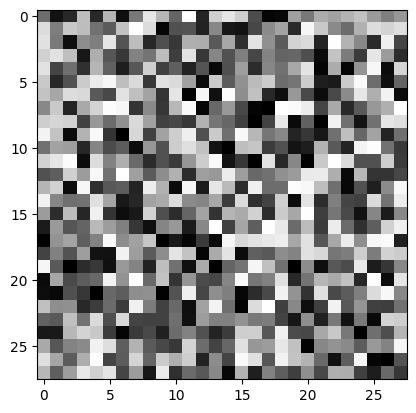

In [17]:
# a. Create a random image (your image should be gray scale with values from 0 to 1, i.e.,normalized).

random_image = np.random.random((28, 28))
plt.imshow(random_image, cmap='gray')
plt.show()

In [18]:
# b. Feed the random image to the model.

predicted = model.predict(random_image.reshape(1, 28, 28, 1)) # Reshaping for batch dimension 
print("Prediction :",predicted)
num = predicted.argmax()
print(f"It looks like: ({num}) with {int(predicted[0][num]*100)}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction : [[0.01223246 0.03806879 0.12441359 0.03948396 0.05317815 0.02828984
  0.00550765 0.20252058 0.49024227 0.00606271]]
It looks like: (8) with 49% confidence


I don't understand why but my model says "8" to all random images with some confidency.

In [19]:
# c. Try to minimize the error in the output by continuously updating the input image using
#    gradient descent.  For this you need to write  a proper loss function  along with some
#    constraints  for regularization (image pixel values to stay within the interval [0,1]).

# example target : [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] # example prediction : [0.04330017, 0.05467458, 0.04155311, 0.0276827, 0.0635523, 0.08241461, 0.05750921, 0.05449867, 0.546441, 0.02837372]
def crossEntropyLoss(target, prediction):
    epsilon = 1e-15 
    loss = -tf.reduce_sum(target * tf.math.log(prediction + epsilon)) 
    return loss

In [14]:
def inputOptimizer(model, image, target, loss_func, learning_rate=0.1, steps=10):
    img = tf.Variable(image, dtype=tf.float32)

    # Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    for step in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            
            # Prediction
            reshaped_image = tf.reshape(img, (1, 28, 28, 1))
            prediction = model(reshaped_image)[0]  

            # Calculate the loss according to given loss function
            loss = loss_func(target, prediction)

        # Calculate the gradients
        gradients = tape.gradient(loss, [img])
        optimizer.apply_gradients(zip(gradients, [img]))  # Update the image with gradient vectors

    # Return optimized Image
    return img.numpy() 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


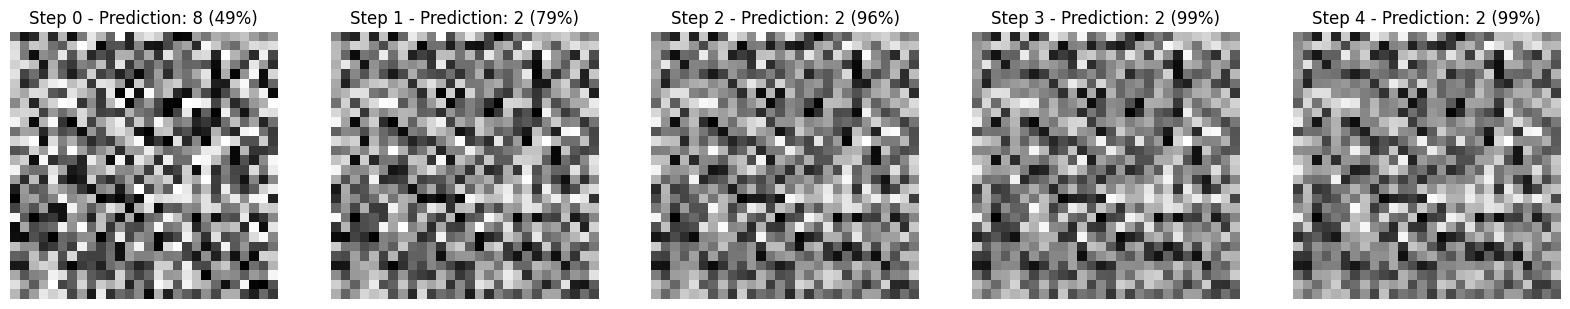

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
It looks like: (2) with 99% confidence


In [20]:
# d. Report the best image found for this. Try this for a few iterations of the random image
#    to see how the optimization is affected by the initial choice of the image.

# Optimize the "random_image" input for "2"
target_class = 2
target = np.zeros(10)
target[target_class] = 1 #[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
optimized_images = []

for i in range(5):
    optimized_image = inputOptimizer(model, random_image, target, crossEntropyLoss, steps=i)
    optimized_images.append(optimized_image)  

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, optimized_image in enumerate(optimized_images):
    axes[i].imshow(optimized_image, cmap='gray') 
    predicted = model.predict(optimized_image.reshape(1, 28, 28, 1)) 
    num = predicted.argmax()
    confidence = int(predicted[0][num] * 100)
    axes[i].set_title(f"Step {i} - Prediction: {num} ({confidence}%)")
    axes[i].axis('off')  

plt.show()  

final_optimized_image = optimized_images[-1]
predicted = model.predict(final_optimized_image.reshape(1, 28, 28, 1))
num = predicted.argmax()
print(f"It looks like: ({num}) with {int(predicted[0][num] * 100)}% confidence")

### **2.2 Model Manipulation**
We can use inputOptimize fuction for manipulating the model for target output. This function forces the model for give wrong outputs. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


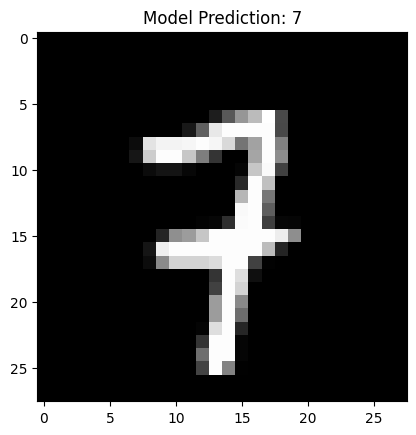

It looks like: (7) with 99% confidence


In [63]:
mnist_image = x_test[307]
predicted = model.predict(mnist_image.reshape(1, 28, 28, 1))

plt.imshow(mnist_image, cmap='gray')
plt.title(f"Model Prediction: {predicted.argmax()}")
plt.show()
num = predicted.argmax()
print(f"It looks like: ({num}) with {int(predicted[0][num]*100)}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


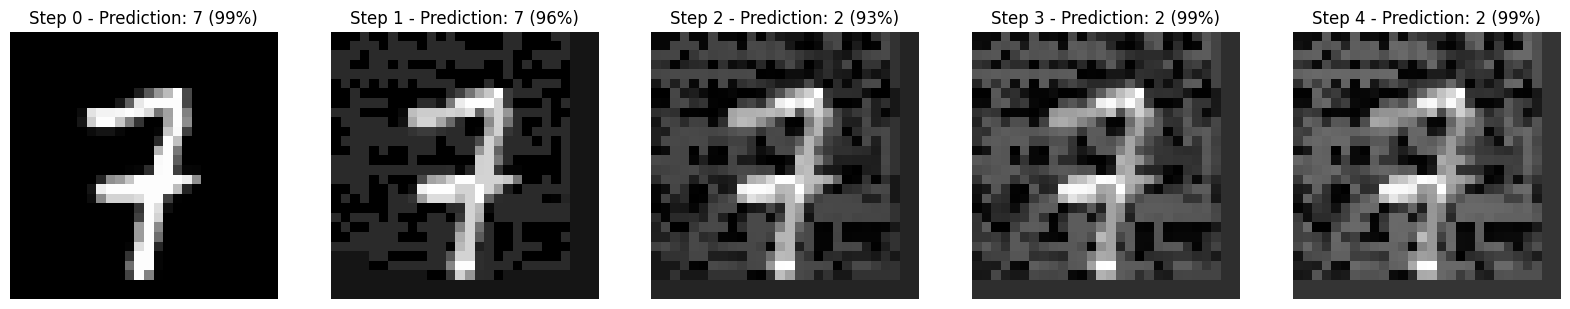

In [65]:
# Manipulate the "7" image for "2" model output
target_class = 2

target = np.zeros(10)
target[target_class] = 1 #[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
manipulated_images = []

for i in range(5):
    manipulated_image = inputOptimizer(model, mnist_image, target, crossEntropyLoss, steps=i)
    manipulated_images.append(manipulated_image)  

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, manipulated_image in enumerate(manipulated_images):
    axes[i].imshow(manipulated_image, cmap='gray') 
    predicted = model.predict(manipulated_image.reshape(1, 28, 28, 1)) 
    num = predicted.argmax()
    confidence = int(predicted[0][num] * 100)
    axes[i].set_title(f"Step {i} - Prediction: {num} ({confidence}%)")
    axes[i].axis('off')  

plt.show()

### **2.3 Low Confidence Output**
* a. All the other digits. For example, for 8 your output is [0,0,0,0,0,0,0,0,1,0].
* b. Set the output to [0,0,0.5,0.5,0,0,0,0,0,0] meaning something between digits 2 and 3.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


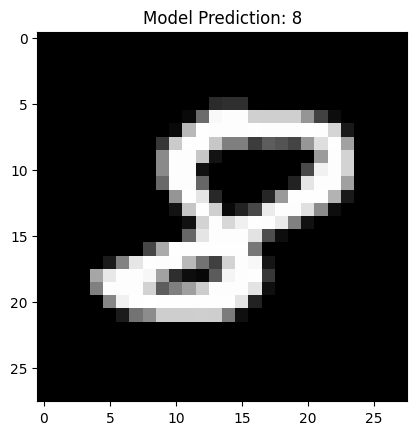

It looks like: (8) with 99% confidence


In [66]:
mnist_image = x_test[61]
predicted = model.predict(mnist_image.reshape(1,28,28,1))
num = predicted.argmax()
plt.imshow(mnist_image, cmap='gray')
plt.title(f"Model Prediction: {num}")
plt.show()
print(f"It looks like: ({num}) with {int(predicted[0][num]*100)}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


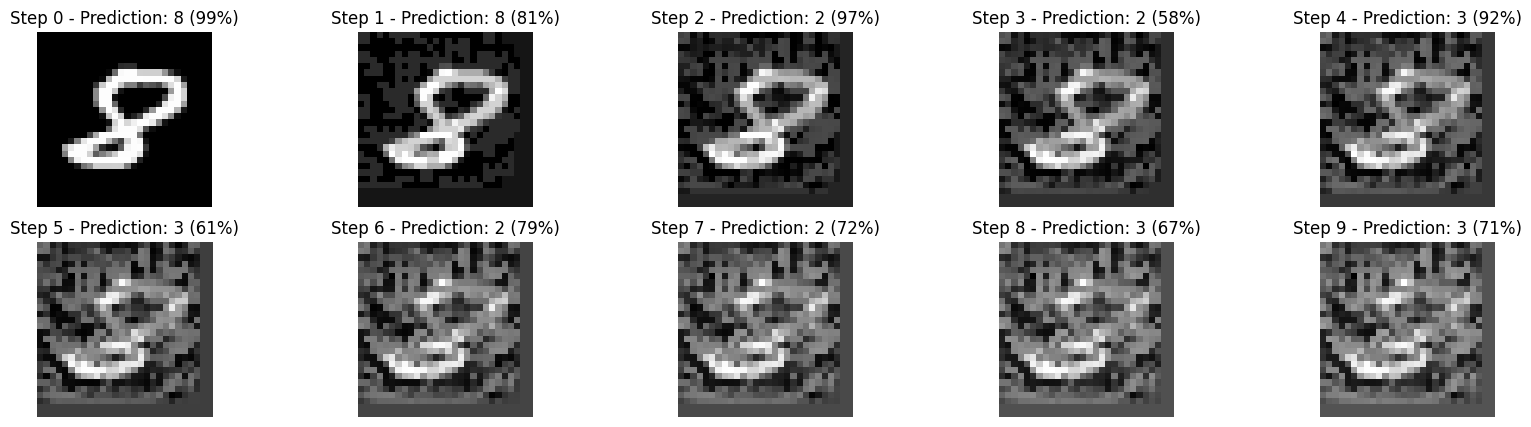

In [69]:
target = [0,0,0.5,0.5,0,0,0,0,0,0]

manipulated_images = []
for i in range(10):
    manipulated_image = inputOptimizer(model, mnist_image, target, crossEntropyLoss, steps=i)
    manipulated_images.append(manipulated_image)  

fig, axes = plt.subplots(2, 5, figsize=(20, 5))

for i, manipulated_image in enumerate(manipulated_images):
    axes[i // 5, i % 5].imshow(manipulated_image, cmap='gray')
    predicted = model.predict(manipulated_image.reshape(1, 28, 28, 1))
    num = predicted.argmax()
    confidence = int(predicted[0][num] * 100)
    axes[i // 5, i % 5].set_title(f"Step {i} - Prediction: {num} ({confidence}%)")
    axes[i // 5, i % 5].axis('off') 

plt.show()

In [68]:
predicted = model.predict(manipulated_images[9].reshape(1, 28, 28, 1))
print(np.round(predicted, 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.   0.   0.29 0.71 0.   0.   0.   0.   0.   0.  ]]


## **Part 2 Conclusion**
In Part 1, I was curious about the model's predictions when applied to random images. To investigate this, I repeatedly generated random images and observed the model's outputs. The model predominantly predicted the number "8" with high confidence for most of the random noise images. This suggests that the model tends to classify these noisy inputs as "8" when it is uncertain about other class labels. This behavior may be mitigated by training the model with both numerical classes and non-numerical images, which could enable the model to output a blank or "no class" response when presented with random noise.

For input optimization, I utilized the crossEntropyLoss function and iteratively updated the noisy random input image using the gradient vectors of the model's output. After 2 to 4 iterations, the image was updated to yield the desired output with high confidence. However, the resulting image still remained an indistinct noise pattern. While this approach does not allow for the generation of meaningful digit images from noise, it can be employed for input manipulation. In one of my experiments, I applied the input optimization technique to a "7" from the MNIST test dataset, causing the model to classify it as "2" with 99% confidence. This technique can be considered a form of neural network manipulation or "hacking."

Finally, I performed input manipulation on an image containing the digit "8" and induced the model to become uncertain, with predictions split approximately 50/50 between "2" and "3." This form of uncertainty was more challenging to achieve. However, because the manipulation was applied quickly (within just a few iterations), the model tended to prefer one of the two predictions ("2" or "3"). After 10 iterations, the "8" image became distorted, and the model reached a prediction of 29% for "2" and 71% for "3."